# Outils de traitement de Corpus
Lucile BESSAC   n°21901117  M1 PluriTAL

Ce notebook détaille les étapes du projet de constitution / exploitation / évaluation d'un corpus.

Le corpus de référence est `katanaml-org/invoices-donut-data-v1` disponible ici `https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1` et l'objectif est de constituer un corpus similaire puis de l'évaluer.


In [95]:
import praw
import os
import glob
import requests

## **I. Récupérer les données : le scrapping**

Mon corpus de référence servant à fine-tuner le modèle de langue Donut qui est un transformer de compréhension de texte sans OCR, je devais récupérer des images contenant du texte ainsi que leur transcription.

J'ai donc choisi de scrapper le fil `r/tumblr` de reddit puisqu'y sont postées des images contenant du texte.

In [96]:
# Initialisation de praw (wrapper de l'API reddit)
reddit = praw.Reddit(client_id="14JBbvpP01tPby97id6m4w",
                    client_secret="5ayqREao03PQKDMmxGTLtCVgaP6OcA",
                    user_agent="klmpost")

In [97]:
# Subreddit à scrapper
subreddit_name = "tumblr"
data_path = "../Data/Raw/Images/"

def crea_dossier(data_path):
    """
    Crée le dossier de stockage des images spécifié s'il n'existe pas.

    Args:
        data_path (str): Le chemin du répertoire à créer.
    """
    if not os.path.exists(data_path):
        os.makedirs(data_path)

crea_dossier(data_path)

In [123]:
# Objet subreddit
subreddit = reddit.subreddit(subreddit_name)

def scrapping_subreddit(subreddit, data_path, limit=100):
    """
    Télécharge les images des posts récents d'un subreddit.

    Args:
        subreddit (praw.models.Subreddit): L'objet subreddit à scrapper.
        data_path (str): Le chemin où les images seront sauvegardées.
        limit (int): Le nombre de posts à analyser.
    """
    print("En train de scrapper le subreddit :", subreddit_name)

    # Pour chacun des X derniers posts
    for post in subreddit.new(limit=limit):
        # Si le post est une image
        if post.url.endswith(('.jpg', '.jpeg', '.png')):
            image_url = post.url
            # Récupère l'image
            image = requests.get(image_url).content
            # Sauvegarde l'image
            with open(os.path.join(data_path, f"{post.id}.jpg"), "wb") as f:
                f.write(image)
            print("Image du post", post.id, "enregistrée dans le fichier",post.id,".jpg")
    print("\n Images enregistrées dans le dossier :", data_path)

# Télécharger les images des posts récents du subreddit
scrapping_subreddit(subreddit, data_path)

En train de scrapper le subreddit : tumblr
Image du post 1cvb6po enregistrée dans le fichier 1cvb6po .jpg
Image du post 1cv9q0n enregistrée dans le fichier 1cv9q0n .jpg
Image du post 1cv7q1k enregistrée dans le fichier 1cv7q1k .jpg
Image du post 1cv72mg enregistrée dans le fichier 1cv72mg .jpg
Image du post 1cv6hny enregistrée dans le fichier 1cv6hny .jpg
Image du post 1cuppez enregistrée dans le fichier 1cuppez .jpg
Image du post 1cubaj5 enregistrée dans le fichier 1cubaj5 .jpg
Image du post 1cua1fn enregistrée dans le fichier 1cua1fn .jpg
Image du post 1cu5vlr enregistrée dans le fichier 1cu5vlr .jpg
Image du post 1cu1sah enregistrée dans le fichier 1cu1sah .jpg
Image du post 1ctwhxb enregistrée dans le fichier 1ctwhxb .jpg
Image du post 1ctusoc enregistrée dans le fichier 1ctusoc .jpg
Image du post 1ctotdh enregistrée dans le fichier 1ctotdh .jpg
Image du post 1ctjs8z enregistrée dans le fichier 1ctjs8z .jpg
Image du post 1cti4eh enregistrée dans le fichier 1cti4eh .jpg
Image du pos

## **II. Rendre les données exploitables : l'OCR**

Afin de récupérer le contenu textuel de mes images, et donc de rendre les données exploitables, j'ai choisi d'essayer d'utiliser l'OCR.

J'ai pour cela utilisé l'outil `pytesseract` de python.

In [98]:
from PIL import Image
import pytesseract
import pandas as pd

In [99]:
def ocr_images(data_path):
    """
    Extrait le texte des images dans un dossier en utilisant l'OCR.

    Args:
        data_path (str): Le chemin du dossier contenant les images.

    Returns:
        dict: Un dictionnaire avec les noms de fichiers d'images comme clés et le contenu extrait comme valeurs.
    """
    dico = {}

    for file_path in glob.glob(os.path.join(data_path, '*')):
        texte = pytesseract.image_to_string(Image.open(file_path))
        file_name = os.path.basename(file_path)
        dico[file_name] = { 'contenu' : [line for line in texte.split('\n')] }
    return dico

# Extraire le texte des images
dico = ocr_images(data_path)
print(dico)

{'1ctjs8z.jpg': {'contenu': ['r ] eldritchbauble Follow _', 'm Jani6', '', "You're just a mammal. Let yourself act like it. Your", 'brain needs enrichment. Your body needs rest. You', 'feel hunger and grow hair. You need to pack bond', "with other sentient things so you don't become", 'unsocialized and neurotic. You are biologically', 'inclined to seek dopamine and become sick when', 'chronically stressed. "Hedonism" is made up to', 'place moral value on taking pleasure in sensory', "experiences. | am telling you that if you don't let", 'yourself be a fucking mammal, as you were made,', 'you will suffer and go insane. No grindset no diets', 'no trying to be above your drive for connection.', 'Pursue what makes you feel good and practice radial', 'rejection of the constructs meant to turn you into a', "machine. You're a mammal.", '', 'eldritchbauble eee', '. Jan 16', '', '| am so serious about the way people are taught', 'to view themselves as separate from and above', 'any other animal

## **III. Stocker les données : Parquet**

J'ai fait le choix de stocker les données au format `.parquet` car c'est le format de stockage de mon corpus de référence. Il s'agit d'un format efficace pour stocker de grandes quantités de données.


In [101]:
folder_path = "../Data/Raw/"
parquet_path = "../Data/Raw/data.parquet"

def save_parquet(dico, folder_path, parquet_path):
    """
    Sauvegarde le dictionnaire contenant les résultats de l'OCR dans un fichier Parquet.

    Args:
        dico (dict): Le dictionnaire à sauvegarder.
        folder_path (str) : Le chemin du dossier contenant le fichier Parquet.
        parquet_path (str): Le chemin du fichier Parquet.
    """

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    df = pd.DataFrame.from_dict(dico, orient='index')

    df.to_parquet(parquet_path, engine="pyarrow")

# Sauvegarder le dictionnaire dans un fichier Parquet
save_parquet(dico, folder_path, parquet_path)

## **IV. Charger les données dans python : Pandas dataframe**

Afin de pouvoir accéder aux données dans python pour les explorer, j'ai choisi de passer par un `DataFrame` Pandas

In [102]:
def load_parquet(parquet_path):
    """
    Lit un fichier Parquet et retourne un DataFrame Pandas.

    Args:
        parquet_path (str): Le chemin du fichier Parquet.

    Returns:
        pd.DataFrame: Le DataFrame lu depuis le fichier Parquet.
    """
    return pd.read_parquet(parquet_path, engine="pyarrow")

# Lire le fichier Parquet
df = load_parquet(parquet_path)
print(df)

                                                       contenu
1ctjs8z.jpg  [r ] eldritchbauble Follow _, m Jani6, , You'r...
1ch543a.jpg  [f mymedlife Follow eee, , WARNING:, , Endosco...
1cln7bm.jpg  [Fi toddchavezwatchescartoons, ef Apr 18, 2024...
1cqk03b.jpg  [& junk-thunder Follow eee, AM, , "is sex with...
1ckz78p.jpg  [as danshive nes, Sep 16, 2023, | enjoy adding...
...                                                        ...
1cqrygv.jpg  [sunshinetheinspiration @ a reblogué, &@ theco...
1crt6gs.jpg  [<= hellsite-hall-of-fame, , £., , @ gayvian, ...
1ckxtsg.jpg  [BaZ celestial-fang Follow, Re. Mar 29, , 3 co...
1clqgwh.jpg  [coco6420 @ "Ss eee, , bro ur interupting my "...
1cm30l9.jpg  [radiofreederry Follow, , THERE'S NOTHING VY S...

[92 rows x 1 columns]


## **V. Rendre les données exploitables : l'annotation**

J'ai fait le choix de ne pas entreprendre l'***annotation morpho-syntaxique*** de mes données car cela ne m'a ***pas semblé pertinent*** pour mon corpus.

## **VI. Visualisation des données : Statistiques de corpus**

Afin d'évaluer les données récoltées et la qualité du corpus, il est intéressant de faire des représentations visuelles des caractéristiques et statistiques du corpus.

Cependant, mon corpus de référence ne contientt que 2 colonnes : l'image & le texte extrait de l'image. Il m'a donc été difficile de trouver des caractéristiques pertinentes et faciles à étudier.

La mesure la plus pertinente aurait été celle de l'exactitude de la transcription par OCR que j'ai effectuée, mais celle-ci nécessite la révision manuelle du contenu textuel de chaque image, qui est une tâche très chronophage.

Je n'ai donc pas effectué cette mesure et il ne me restait que peu de choix.

J'ai tout de même choisi des caractéristiques que j'ai divisées en 2 catégories.
- Caractéristiques qualitatives
- Caractéristiques quantitatives

### ***1. Caractéristiques qualitatives***

- Dimension des images en pixels
- Longueur des transcriptions en nombre de lignes

*Puisque les images sont des captures d'écran de threads Tumblr, l'hypothèse est qu'il y a une correlation entre ces valeurs*

On commence par récupérer les informations et les stocker dans une liste :

In [103]:
import matplotlib.pyplot as plt

def recuperation_infos_images(file_path):
    """
    Récupère la taille et les dimensions d'une image.
    
    Args:
    file_path (str): Chemin vers le fichier image.
    
    Returns:
    tuple: Taille de l'image en octets, largeur et hauteur.
    """
    if os.path.exists(file_path):
        taille = os.path.getsize(file_path)
        with Image.open(file_path) as img:
            larg, long = img.size
        return taille, larg, long

def sauvegarde_infos_images(folder_path):
    """
    Collecte les informations de toutes les images dans un dossier, dans une liste.
    
    Args:
    folder_path (str): Chemin vers le dossier contenant les images.
    
    Returns:
    list: Liste de tuples contenant les informations des images.
    """
    donnees_images = []
    for file_path in glob.glob(os.path.join(folder_path, '*')):
        taille, larg, long = recuperation_infos_images(file_path)
        donnees_images.append((file_path, taille, larg, long))

    return donnees_images

Puis on génère les graphes correspondant pour mieux visualiser les données :

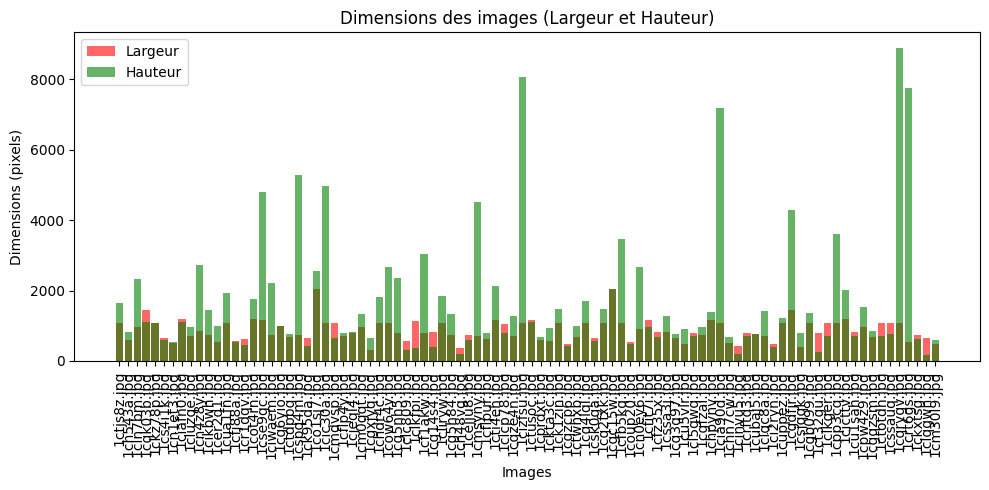

In [108]:
def generation_graphe_dimension_images(donnees_images, graphes_path):
    """
    Génère des graphiques basés sur les informations des images et les enregistre.
    
    Args:
    donnees_images (list): Liste de tuples contenant les informations des images.
    graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.
    """
    if not os.path.exists(graphes_path):
        os.makedirs(graphes_path)
    
    file_names = [os.path.basename(info[0]) for info in donnees_images]
    largs = [info[2] for info in donnees_images]
    longs = [info[3] for info in donnees_images]
    
    # Graphique des dimensions d'images (largeur et hauteur)
    plt.figure(figsize=(10, 5))
    plt.bar(file_names, largs, color='red', alpha=0.6, label='Largeur')
    plt.bar(file_names, longs, color='green', alpha=0.6, label='Hauteur')
    plt.xlabel('Images')
    plt.ylabel('Dimensions (pixels)')
    plt.title('Dimensions des images (Largeur et Hauteur)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    dimensions_graph_path = os.path.join(graphes_path, 'dimensions_images.png')
    plt.savefig(dimensions_graph_path)
    plt.show()
    plt.close()

# Chemin vers le dossier contenant les images
folder_path = '../Data/Raw/Images'
graphes_path = "../Figures/"

# Collecter les informations des images
donnees_images = sauvegarde_infos_images(folder_path)

# Générer les graphiques basés sur les informations des images
generation_graphe_dimension_images(donnees_images, graphes_path)


Cette représentation permet de se rendre compte que certaines images sont beaucoup plus hautes que d'autres, sûrement parce-qu'elles contiennent un un thread assez long, avec beaucoup de réponses.

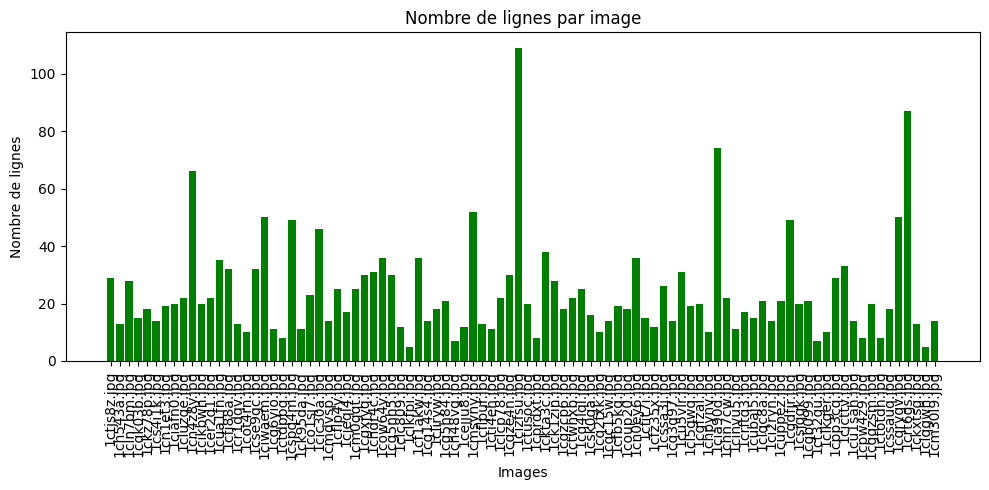

In [105]:

def generation_graphe_dimension_textes(df, graphes_path):
    """
    Génère un graphe montrant la dimension en nombre de lignes de texte.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données OCR.
    """
    # Calculer la longueur en nombre de lignes de chaque image de la liste
    df['num_elements'] = df['contenu'].apply(len)

    # Générer le graphique pour la longueur en nombre d'éléments de la liste
    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df['num_elements'], color='green')
    plt.xlabel('Images')
    plt.ylabel('Nombre de lignes')
    plt.title('Nombre de lignes par image')
    plt.xticks(rotation=90)
    plt.tight_layout()
    dimensions_graph_path = os.path.join(graphes_path, 'dimensions_textes.png')
    plt.savefig(dimensions_graph_path)
    plt.show()
    plt.close()

# Générer les graphiques basés sur les informations des images
generation_graphe_dimension_textes(df, graphes_path)


Cette représentation permet de se rendre compte que certaines images contiennent de nombreuses lignes de texte, et d'autres, peu.
Les images contenant peu de texte ne sont peut-être pas pertinentes à conserver.

### ***2. Caractéristiques quantitatives***
Maintenant que nous avons pu observer la taille des images et le nombre de lignes de texte qu'elles contiennent, observons des caractéristiques quantitatives.

- Nombre d'images
- Taille (poids) des images en octets
- Taille des transcriptions en nombre de tokens

*Une grande différence entre le poids de l'image et le nombre de tokens dans la transcription peut indiquer que l'image contient beaucoup plus de données graphiques que de données textuelles et n'est donc pas pertinente pour notre corpus.*

In [109]:
nb_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
print("Le corpus contient", nb_images, "images et leur transcription")

Le corpus contient 92 images et leur transcription


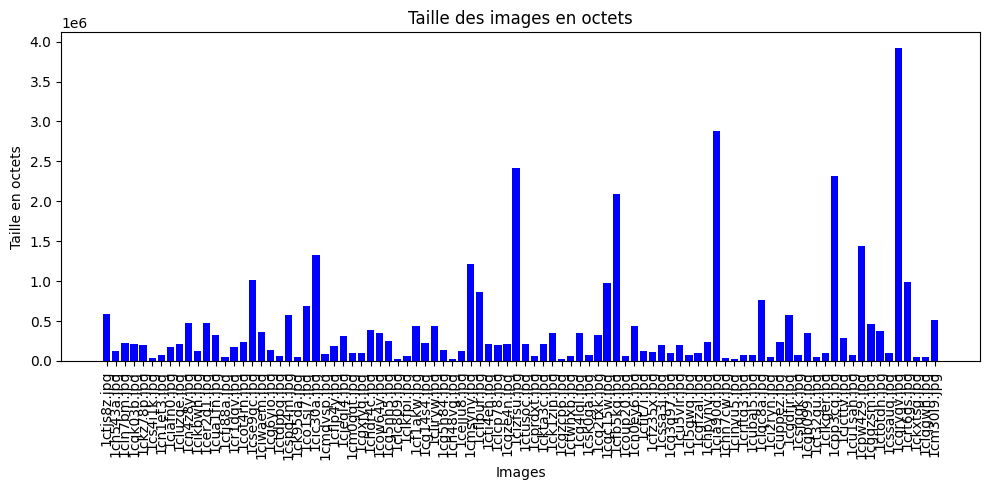

In [110]:
def generation_graphe_taille_images(donnees_images, graphes_path):
    """
    Génère des graphiques basés sur les informations des images et les enregistre.
    
    Args:
    donnees_images (list): Liste de tuples contenant les informations des images.
    graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.
    """

    file_names = [os.path.basename(info[0]) for info in donnees_images]
    tailles = [info[1] for info in donnees_images]
    
    # Graphique des tailles d'images
    plt.figure(figsize=(10, 5))
    plt.bar(file_names, tailles, color='blue')
    plt.xlabel('Images')
    plt.ylabel('Taille en octets')
    plt.title('Taille des images en octets')
    plt.xticks(rotation=90)
    plt.tight_layout()
    taille_graph_path = os.path.join(graphes_path, 'taille_images.png')
    plt.savefig(taille_graph_path)
    plt.show()
    plt.close()


# Générer les graphiques basés sur les informations des images
generation_graphe_taille_images(donnees_images, graphes_path)

Cette représentation permet de nous rendre compte que certaines images sont très lourdes. En comparant avaec le nombre de tokens, nous pourrons déterminer si c'est parce-qu'elles contiennent beaucoup de texte ou pas.

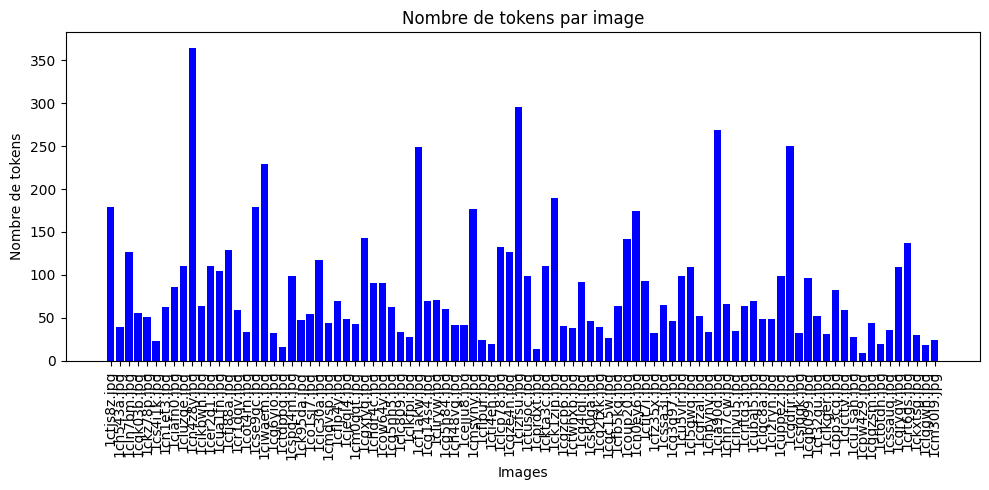

In [111]:
def generation_graphe_taille_textes(df, graphes_path):
    """
    Génère un graphe montrant la taille en nombre de tokens.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données OCR.
        graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.

    """
    # Calculer la longueur en nombre de tokens des images de la liste
    df['num_tokens'] = df['contenu'].apply(lambda x: sum(len(line.split()) for line in x))

    # Générer le graphique pour la longueur en nombre de tokens
    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df['num_tokens'], color='blue')
    plt.xlabel('Images')
    plt.ylabel('Nombre de tokens')
    plt.title('Nombre de tokens par image')
    plt.xticks(rotation=90)
    plt.tight_layout()
    taille_graph_path = os.path.join(graphes_path, 'taille_textes.png')
    plt.savefig(taille_graph_path)
    plt.show()
    plt.close()
# Générer les graphiques basés sur les informations des images
generation_graphe_taille_textes(df, graphes_path)


Cette représentation nous permet d'observer quelles images contiennent le moins de tokens, et ne sont donc peut-être pas pertinentes pour notre corpus.

## **VII. Nettoyage du corpus**

Une fois les informations sur le corpus visualisées, nous pouvons les comparer afin de définir quels éléments du corpus ne sont pas pertinents et peuvent être supprimés.

***Commençons par comparer les mesures qualitatives :***

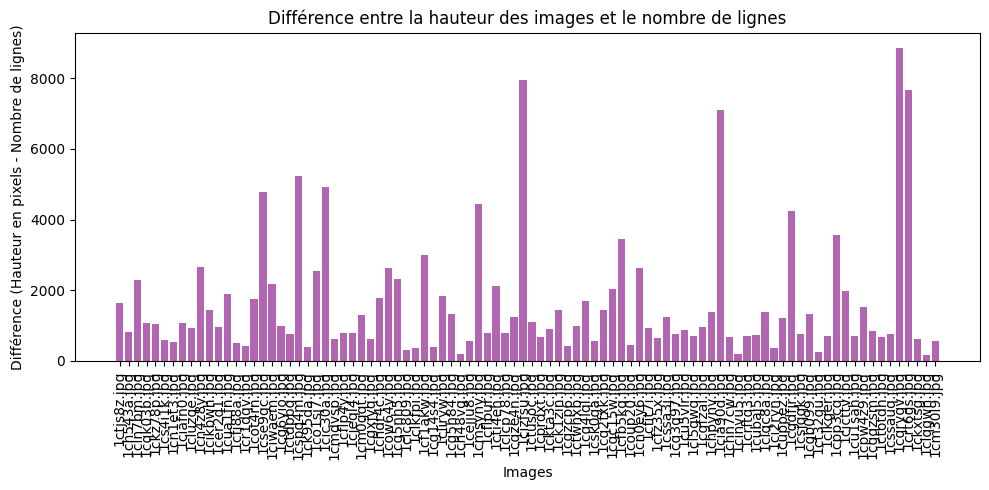

In [113]:
def generation_graphe_dimension_comparaison(donnees_images, graphes_path, df):
    """
    Génère un graphique comparant la hauteur des images et le nombre de lignes de texte.

    Args:
    donnees_images (list): Liste de tuples contenant les informations des images.
    graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.
    df (pd.DataFrame): Le DataFrame contenant les données OCR.
    """
    if not os.path.exists(graphes_path):
        os.makedirs(graphes_path)
    
    file_names = [os.path.basename(info[0]) for info in donnees_images]
    longs = [info[3] for info in donnees_images]
    df['num_elements'] = df['contenu'].apply(len)
    differences = [long - num_elements for num_elements, long in zip(df['num_elements'], longs)]

    # Graphique de la différence entre le nombre d'éléments et la hauteur des images
    plt.figure(figsize=(10, 5))
    plt.bar(file_names, differences, color='purple', alpha=0.6)
    plt.xlabel('Images')
    plt.ylabel('Différence (Hauteur en pixels - Nombre de lignes)')
    plt.title('Différence entre la hauteur des images et le nombre de lignes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    difference_graph_path = os.path.join(graphes_path, 'difference_dimension_images_textes.png')
    plt.savefig(difference_graph_path)
    plt.show()
    plt.close()

# Chemin vers le dossier contenant les images
folder_path = '../Data/Raw/Images'
graphes_path = "../Figures/"

# Générer le graphique de la différence entre le nombre d'éléments et la hauteur des images
generation_graphe_dimension_comparaison(donnees_images, graphes_path, df)

Cette comparaison entre la hauteur des images et le nombre de lignes permet d'inférer que là où la différence est la plus grande, les images contiennent trop peu de lignes de texte pour être pertinentes.

### ***Éliminer les données abérrantes***

**Après vérification manuelle** :
- `1cqrygv.jpg`, `1crt6gs.jpg` et `1cspq4m.jpg` qui ont une grosse différence contiennent trop d'images et ont été supprimés du corpus


In [126]:
import shutil

# Chemins des fichiers et des dossiers
raw_parquet_path = '../Data/Raw/data.parquet'
clean_parquet_path = '../Data/Clean/data.parquet'
raw_image_folder_path = '../Data/Raw/Images'
clean_image_folder_path = '../Data/Clean/Images'

# Crée les dossiers s'ils n'existent pas
os.makedirs(os.path.dirname(clean_parquet_path), exist_ok=True)
os.makedirs(clean_image_folder_path, exist_ok=True)

# Images à supprimer
suppr = ['1cqrygv.jpg', '1crt6gs.jpg', '1cspq4m.jpg', '1cpp3cq.jpg']

# Charger le corpus au format Parquet
df = pd.read_parquet(raw_parquet_path)

# Filtrer les DataFrame pour supprimer les éléments associés aux images à supprimer
df = df.drop(index=suppr, errors='ignore')

# Sauvegarder le DataFrame filtré dans un fichier Parquet
df.to_parquet(clean_parquet_path, engine='pyarrow')

# Fonction pour copier les images restantes
def copie_images_restantes(df, raw_folder, clean_folder):
    """
    Copie les images restantes d'un DataFrame depuis un dossier source vers un dossier de destination.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les noms des images dans son index.
        raw_folder (str): Le chemin vers le dossier source contenant les images.
        clean_folder (str): Le chemin vers le dossier de destination où les images seront copiées.

    """
    for image in df.index:
        src_path = os.path.join(raw_folder, image)
        dest_path = os.path.join(clean_folder, image)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

# Copier les images restantes dans le dossier Clean
copie_images_restantes(df, raw_image_folder_path, clean_image_folder_path)

# Supprimer les images spécifiées du dossier Raw
for image in suppr:
    image_path = os.path.join(raw_image_folder_path, image)
    if os.path.exists(image_path):
        os.remove(image_path)

# Sauvegarder les images restantes dans le dossier Clean
print("Les images et les items associés ont été supprimés, et les images restantes ont été stockées dans le dossier Clean.")


Les images et les items associés ont été supprimés, et les images restantes ont été stockées dans le dossier Clean.


### ***Mesurer la corrélation entre deux variables***

Afin de sélectionner les caractéristiques à mettre en relation pour observer les données, j'ai tenté de mesurer la corrélation de mes variables en les représentant dans le même espace :

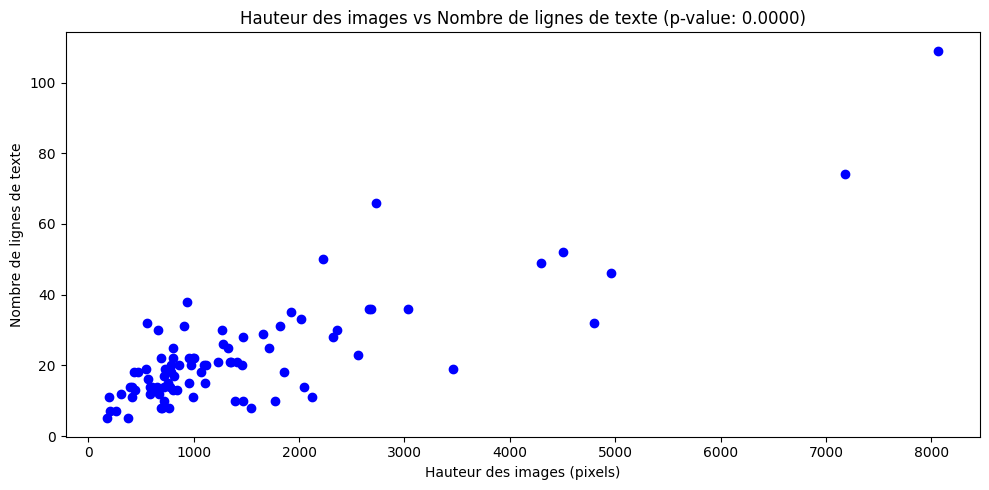

In [127]:
import scipy.stats as stats

def generation_graphe_dimension_comparaison(donnees_images, graphes_path, df):
    """
    Génère un graphique comparant la hauteur des images et le nombre de lignes de texte.

    Args:
    donnees_images (list): Liste de tuples contenant les informations des images.
    graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.
    df (pd.DataFrame): Le DataFrame contenant les données OCR.
    """
    if not os.path.exists(graphes_path):
        os.makedirs(graphes_path)
    
    file_names = [os.path.basename(info[0]) for info in donnees_images]
    longs = [info[3] for info in donnees_images]
    df['num_elements'] = df['contenu'].apply(len)
    
    # Calcul de la p-value entre longs et num_elements
    correlation, p_value = stats.pearsonr(longs, df['num_elements'])
    
    # Graphique de la différence entre le nombre d'éléments et la hauteur des images
    plt.figure(figsize=(10, 5))
    plt.scatter(longs, df['num_elements'], color='blue')
    plt.xlabel('Hauteur des images (pixels)')
    plt.ylabel('Nombre de lignes de texte')
    plt.title(f'Hauteur des images vs Nombre de lignes de texte (p-value: {p_value:.4f})')
    plt.tight_layout()
    scatter_plot_path = os.path.join(graphes_path, 'scatter_dimension_images_textes.png')
    plt.savefig(scatter_plot_path)
    plt.show()
    plt.close()

# Chemin vers le dossier contenant les images
folder_path = '../Data/Clean/Images'
graphes_path = "../Figures/"

# Collecter les informations des images
donnees_images = sauvegarde_infos_images(folder_path)

# Générer le graphique de la différence entre le nombre d'éléments et la hauteur des images
generation_graphe_dimension_comparaison(donnees_images, graphes_path, df)


J'en concluerais que les données ne corrèlent pas mais pour en avoir le coeur net il faudrait calculer la p-value et je n'ai pas réussi.

***Comparons en suite les mesures quantitatives :***

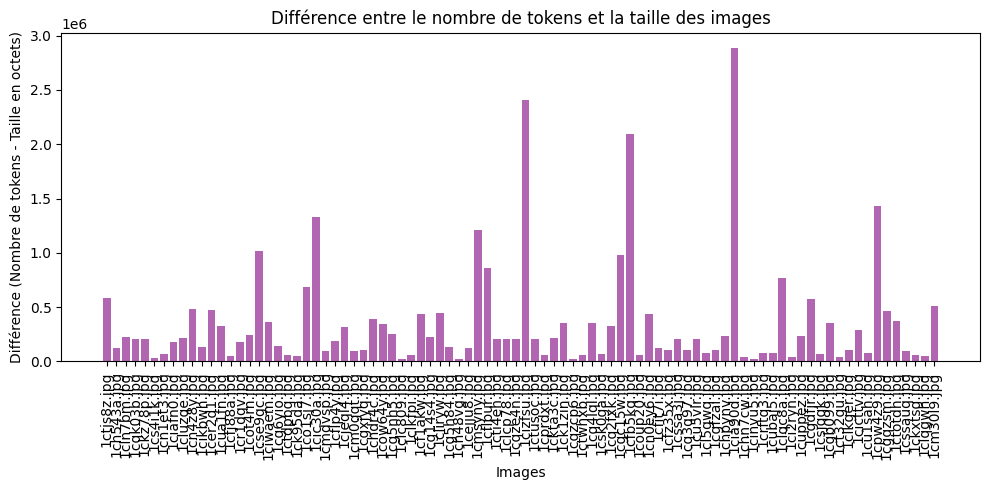

In [130]:
def generation_graphe_taille_comparaison(donnees_images, graphes_path, df):
    """
    Génère un graphique comparant la taille des images et le nombre de tokens de la transcription.

    Args:
    donnees_images (list): Liste de tuples contenant les informations des images.
    graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.
    df (pd.DataFrame): Le DataFrame contenant les données OCR.
    """
    if not os.path.exists(graphes_path):
        os.makedirs(graphes_path)
    
    file_names = [os.path.basename(info[0]) for info in donnees_images]
    tailles = [info[1] for info in donnees_images]
    df['num_tokens'] = df['contenu'].apply(lambda x: sum(len(line.split()) for line in x))
    differences = [taille - num_elements for num_elements, taille in zip(df['num_elements'], tailles)]

    # Graphique de la différence entre le nombre d'éléments et la hauteur des images
    plt.figure(figsize=(10, 5))
    plt.bar(file_names, differences, color='purple', alpha=0.6)
    plt.xlabel('Images')
    plt.ylabel('Différence (Nombre de tokens - Taille en octets)')
    plt.title('Différence entre le nombre de tokens et la taille des images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    difference_graph_path = os.path.join(graphes_path, 'difference_taille_images_textes.png')
    plt.savefig(difference_graph_path)
    plt.show()
    plt.close()

# Chemin vers le dossier contenant les images
folder_path = '../Data/Raw/Images'
graphes_path = "../Figures/"

# Générer le graphique de la différence entre le nombre d'éléments et la hauteur des images
generation_graphe_taille_comparaison(donnees_images, graphes_path, df)

Nous pouvons ici supposer que les images ayant la plus grande différence entre le nombre de tokens et le poids de l'image sont trop lourdes en comparaison de la quantité de texte extraite et devraient donc être supprimées du corpus.

### ***Éliminer les données abérrantes***


**Après vérification manuelle** :
- `1cpp3cq.jpg`, qui a une grosse différence contient trop d'images et a été supprimé du corpus


### ***Mesurer la corrélation entre deux variables***

Afin de sélectionner les caractéristiques à mettre en relation pour observer les données, j'ai tenté de mesurer la corrélation de mes variables en les représentant dans le même espace :

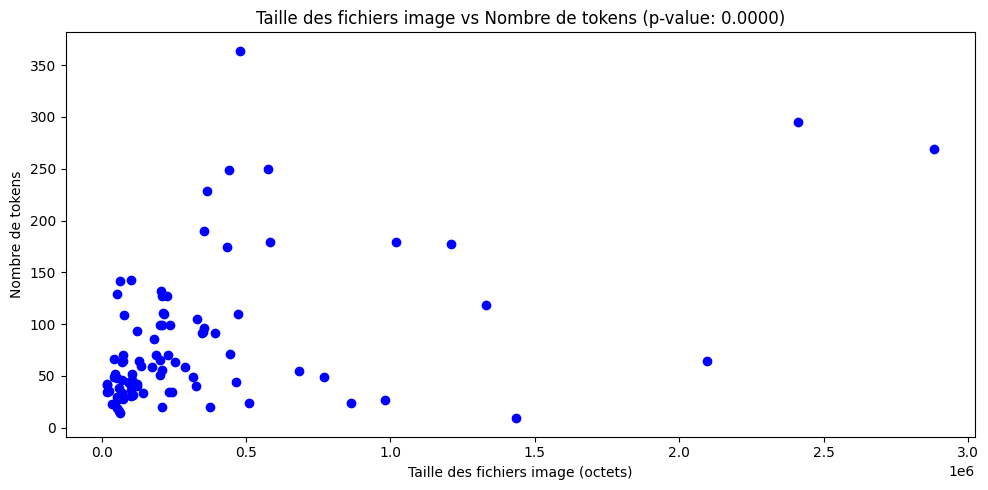

In [132]:
def generation_graphe_taille_comparaison(donnees_images, graphes_path, df):
    """
    Génère un graphique comparant la taille des images et le nombre de tokens de la transcription.

    Args:
    donnees_images (list): Liste de tuples contenant les informations des images.
    graphes_path (str): Chemin vers le dossier où les graphes seront sauvegardés.
    df (pd.DataFrame): Le DataFrame contenant les données OCR.
    """
    if not os.path.exists(graphes_path):
        os.makedirs(graphes_path)
    
    file_names = [os.path.basename(info[0]) for info in donnees_images]
    tailles = [info[1] for info in donnees_images]
    df['num_tokens'] = df['contenu'].apply(lambda x: sum(len(line.split()) for line in x))

    # Calcul de la p-value entre tailles et num_tokens
    correlation, p_value = stats.pearsonr(tailles, df['num_tokens'])

    # Graphique de la taille des fichiers image vs. nombre de tokens
    plt.figure(figsize=(10, 5))
    plt.scatter(tailles, df['num_tokens'], color='blue')
    plt.xlabel('Taille des fichiers image (octets)')
    plt.ylabel('Nombre de tokens')
    plt.title(f'Taille des fichiers image vs Nombre de tokens (p-value: {p_value:.4f})')
    plt.tight_layout()
    scatter_plot_path = os.path.join(graphes_path, 'taille_images_tokens.png')
    plt.savefig(scatter_plot_path)
    plt.show()
    plt.close()

# Chemin vers le dossier contenant les images
folder_path = '../Data/Clean/Images'
graphes_path = "../Figures/"

# Collecter les informations des images
donnees_images = sauvegarde_infos_images(folder_path)

# Générer le graphique comparant la taille des images et le nombre de tokens
generation_graphe_taille_comparaison(donnees_images, graphes_path, df)


J'en concluerais que les données ne corrèlent pas mais pour en avoir le coeur net il faudrait calculer la p-value et je n'ai pas réussi.

## **VIII. Split du corpus en test et train**

In [134]:
from sklearn.model_selection import train_test_split

# Chemins des fichiers et des dossiers
parquet_path = '../Data/Clean/data.parquet'
train_parquet_path = '../Data/Clean/Train/train_data.parquet'
test_parquet_path = '../Data/Clean/Test/test_data.parquet'
image_folder_path = '../Data/Clean/Images'
train_image_folder_path = '../Data/Clean/Train/Images'
test_image_folder_path = '../Data/Clean/Test/Images'

# Fonction pour créer les dossiers s'ils n'existent pas
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Crée les dossiers s'ils n'existent pas
create_folder_if_not_exists(os.path.dirname(train_parquet_path))
create_folder_if_not_exists(os.path.dirname(test_parquet_path))
create_folder_if_not_exists(train_image_folder_path)
create_folder_if_not_exists(test_image_folder_path)

# Charger le corpus au format Parquet
df = pd.read_parquet(parquet_path)

# Diviser le corpus en ensembles d'entraînement et de test (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Sauvegarder les ensembles d'entraînement et de test en fichiers Parquet distincts
train_df.to_parquet(train_parquet_path, engine='pyarrow')
test_df.to_parquet(test_parquet_path, engine='pyarrow')

def copy_images(image_names, raw_folder, dest_folder):
    """
    Copie les images d'une liste depuis le dossier source vers le dossier de destination.
    
    Args:
    image_names (list): Liste des noms d'images à copier.
    raw_folder (str): Chemin vers le dossier source.
    dest_folder (str): Chemin vers le dossier de destination.
    """
    for image_name in image_names:
        src_path = os.path.join(raw_folder, image_name)
        dest_path = os.path.join(dest_folder, image_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Image {image_name} non trouvée dans le dossier source.")

# Copier les images correspondantes dans les dossiers d'entraînement et de test
train_image_names = train_df.index.to_list()
test_image_names = test_df.index.to_list()

copy_images(train_image_names, image_folder_path, train_image_folder_path)
copy_images(test_image_names, image_folder_path, test_image_folder_path)

print("Les ensembles d'entraînement et de test ont été créés et les images correspondantes ont été copiées.")


Les ensembles d'entraînement et de test ont été créés et les images correspondantes ont été copiées.


## **IX. Métriques d'évaluation**

Comme expliqué précédemment, mon corpus de référence ne contientt que 2 colonnes : l'image & le texte extrait de l'image. Il m'a donc été difficile de trouver des métriques d'évaluation.

La mesure la plus pertinente aurait été celle de l'exactitude de la transcription par OCR que j'ai effectuée, qui aurait consisté à comparer les transcriptions de mon corpus avec les traductions excates effectuées par un humain, mais celle-ci nécessite la révision manuelle du contenu textuel de chaque image, qui est une tâche très chronophage.

Je n'ai donc pas effectué cette mesure.

À la place,puisque certaines images ont été supprimées, on peut imaginer vérifier si chaque item contenu dans le corpus texte a bel et bien une image qui lui est associée. Cela permettrait de vérifier qu'auncun item n'est orphelin.